In [1]:
import os
import itertools
import xlsxwriter

import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

import DataPreparation as dpr
import ModelRun as mr
import benchmarks as bench
from MyEstimators import CLS_Estimator

<Figure size 720x360 with 0 Axes>

### Load data

In [2]:
df = dpr.read_data('EQP_Quarterly')
df = dpr.data_clean(df, '1956-01-01')

In [3]:
df.head()

,EQP,DP,DY,EP,DE,svar,b/m,ntis,tbl,lty,...,TMS,DFR,DFY,infl,c,w,y,cay,AAA,BAA
time,,,,,,,,,,,,,,,,,,,,,
1956-03-01,0.066512,-3.333030,-3.269151,-2.575525,-0.757505,0.003289,0.531077,0.026695,0.0225,0.0303,...,0.0078,0.005159,0.0050,0.000000,9.272498,11.092725,9.100386,0.007275,0.0310,0.0360
1956-06-01,-0.028264,-3.261722,-3.293365,-2.568575,-0.693147,0.003688,0.551565,0.025672,0.0249,0.0299,...,0.0050,-0.021824,0.0050,0.014925,9.271728,11.091665,9.107828,0.000775,0.0326,0.0376
1956-09-01,-0.034415,-3.204645,-3.239744,-2.573142,-0.631503,0.002519,0.571910,0.029362,0.0284,0.0324,...,0.0040,0.005663,0.0051,0.007353,9.269304,11.086198,9.106428,0.000663,0.0356,0.0407
1956-12-01,0.033241,-3.289216,-3.260525,-2.616389,-0.672827,0.004394,0.544177,0.026149,0.0321,0.0345,...,0.0024,-0.002208,0.0062,0.007299,9.277993,11.096678,9.118405,-0.002524,0.0375,0.0437
1957-03-01,-0.050750,-3.238565,-3.294980,-2.562911,-0.675654,0.002288,0.599819,0.026600,0.0308,0.0331,...,0.0023,-0.000368,0.0077,0.007246,9.280482,11.090721,9.117433,0.002041,0.0366,0.0443


### Add $y_{t-1}, y_{t-2}$ and construct X and y

In [4]:
df['y_lag'] = df['EQP'].shift(1)
df = df.dropna()
df.head()

,EQP,DP,DY,EP,DE,svar,b/m,ntis,tbl,lty,...,DFR,DFY,infl,c,w,y,cay,AAA,BAA,y_lag
time,,,,,,,,,,,,,,,,,,,,,
1956-06-01,-0.028264,-3.261722,-3.293365,-2.568575,-0.693147,0.003688,0.551565,0.025672,0.0249,0.0299,...,-0.021824,0.0050,0.014925,9.271728,11.091665,9.107828,0.000775,0.0326,0.0376,0.066512
1956-09-01,-0.034415,-3.204645,-3.239744,-2.573142,-0.631503,0.002519,0.571910,0.029362,0.0284,0.0324,...,0.005663,0.0051,0.007353,9.269304,11.086198,9.106428,0.000663,0.0356,0.0407,-0.028264
1956-12-01,0.033241,-3.289216,-3.260525,-2.616389,-0.672827,0.004394,0.544177,0.026149,0.0321,0.0345,...,-0.002208,0.0062,0.007299,9.277993,11.096678,9.118405,-0.002524,0.0375,0.0437,-0.034415
1957-03-01,-0.050750,-3.238565,-3.294980,-2.562911,-0.675654,0.002288,0.599819,0.026600,0.0308,0.0331,...,-0.000368,0.0077,0.007246,9.280482,11.090721,9.117433,0.002041,0.0366,0.0443,0.033241
1957-06-01,0.075114,-3.309868,-3.238565,-2.628349,-0.681519,0.001363,0.565877,0.030528,0.0329,0.0361,...,-0.003789,0.0072,0.010791,9.278119,11.104916,9.118823,-0.004528,0.0391,0.0463,-0.050750


In [5]:
df_AR2 = df.copy()
df_AR2['y_2lag'] = df['y_lag'].shift(1)
df_AR2 = df_AR2.dropna()
df_AR2.head()

,EQP,DP,DY,EP,DE,svar,b/m,ntis,tbl,lty,...,DFY,infl,c,w,y,cay,AAA,BAA,y_lag,y_2lag
time,,,,,,,,,,,,,,,,,,,,,
1956-09-01,-0.034415,-3.204645,-3.239744,-2.573142,-0.631503,0.002519,0.571910,0.029362,0.0284,0.0324,...,0.0051,0.007353,9.269304,11.086198,9.106428,0.000663,0.0356,0.0407,-0.028264,0.066512
1956-12-01,0.033241,-3.289216,-3.260525,-2.616389,-0.672827,0.004394,0.544177,0.026149,0.0321,0.0345,...,0.0062,0.007299,9.277993,11.096678,9.118405,-0.002524,0.0375,0.0437,-0.034415,-0.028264
1957-03-01,-0.050750,-3.238565,-3.294980,-2.562911,-0.675654,0.002288,0.599819,0.026600,0.0308,0.0331,...,0.0077,0.007246,9.280482,11.090721,9.117433,0.002041,0.0366,0.0443,0.033241,-0.034415
1957-06-01,0.075114,-3.309868,-3.238565,-2.628349,-0.681519,0.001363,0.565877,0.030528,0.0329,0.0361,...,0.0072,0.010791,9.278119,11.104916,9.118823,-0.004528,0.0391,0.0463,-0.050750,0.033241
1957-09-01,-0.108352,-3.182306,-3.292675,-2.503465,-0.678841,0.004218,0.624151,0.034363,0.0353,0.0364,...,0.0081,0.007117,9.281519,11.089344,9.117364,0.003433,0.0412,0.0493,0.075114,-0.050750


### Construct single-index and nonlinear models

In [6]:
def single_index(x):
    if isinstance(x, (pd.DataFrame, np.ndarray)):
        if isinstance(x, pd.DataFrame):
            x_values = x.values
        else:
            pass
    else:
        raise Exception('wrong type')

    def u(theta):
        if len(theta) == x_values.shape[1]:
            sum_up = [x_values[:, i] * theta[i] for i in range(x_values.shape[1])]
            index = np.sum(sum_up, axis=0)
        else:
            raise Exception('wrong parameter dimension')
        return index

    return u

In [7]:
extra_params = {'sin_func':1,
               'cos_func':1,
               'scaled_sin_func':2,
               'scaled_cos_func':2,
               'exp_func':2,
               'exp_shift_func':2,
                'poly_func':3,
                'linear_func':2
               }

In [8]:
def dimensions(non_sta, sta, func):
    stas = sta.shape[1]
    nonstas = non_sta.shape[1]
    extra = range(0, extra_params[func])
    return nonstas, stas, extra

In [9]:
def sin_func(x):
    def objective_func(params):
        func = np.sin(single_index(x.iloc[:,:d1])(params[0:d1])+params[d1+d2+extra[0]])+np.dot(
            x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [10]:
def cos_func(x):
    def objective_func(params):
        func = np.cos(single_index(x.iloc[:,:d1])(params[0:d1])+params[d1+d2+extra[0]])+np.dot(
            x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [11]:

def scaled_sin_func(x):
    def objective_func(params):
        func = np.sin(params[d1+d2+extra[1]]*single_index(x.iloc[:,:d1])(
            params[0:d1])+params[d1+d2+extra[0]])+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [12]:
def scaled_cos_func(x):
    def objective_func(params):
        func = np.cos(params[d1+d2+extra[1]]*single_index(x.iloc[:,:d1])(
            params[0:d1])+params[d1+d2+extra[0]])+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [13]:


def exp_shift_func(x):
    def objective_func(params):
        func = 1 - np.exp(params[d1+d2+extra[1]]*((single_index(x.iloc[:,:d1])(
            params[0:d1]))-params[d1+d2+extra[0]])**2)+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [14]:
def exp_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]*np.exp(-params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(params[0:d1]))**2
                                )+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
        return func
    return objective_func

In [15]:
def poly_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]+params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
            params[0:d1]))+params[d1+d2+extra[2]]*((single_index(x.iloc[:,:d1])(
            params[0:d1]))**2)+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
#                (single_index(x.iloc[:,:d1])(params[0:d1])
        return func
    return objective_func

In [16]:
def linear_func(x):
    def objective_func(params):
        func = params[d1+d2+extra[0]]+params[d1+d2+extra[1]]*(single_index(x.iloc[:,:d1])(
            params[0:d1]))+np.dot(x.iloc[:,d1:d1+d2], params[d1:d1+d2])
#                (single_index(x.iloc[:,:d1])(params[0:d1])
        return func
    return objective_func

### Model Estimation

In [17]:
def constraint_func(x):
    def constraint(params):
        con = 0
        for j in np.arange(0, x.iloc[:,:d1].shape[1]):
            con += params[j]**2
            cons = con - 1
        return cons
    return {'type':'eq', 'fun': constraint}

In [18]:
# d1, d2, extra = dimensions(co1, station_ar2,'poly_func')
# cls_nls = CLS_Estimator(obj_func = sin_func, x0 = [0.001]*(d1+d2+extra[-1]+1), options={'maxiter':50000})
# cls = CLS_Estimator(obj_func = poly_func, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X), options={'maxiter':50000})

In [19]:
# cls_nls.fit(co1.join(station_ar2),y_lag2)
# cls.fit(co1.join(station_ar2),y_lag2)

## Empirical Study

### Cointegrated predictors
- dividend-price ratio and dividend yield
- T-bill rate and long-term yield
- dividend-price ratio and earningprice ratio
- baa- and aaa-rated corporate bond yields

In [20]:
co1 = df[['DP', 'DY']]
co2 = df[['tbl', 'lty']]
co3 = df[['DP', 'EP']]
co4 = df[['BAA', 'AAA']]
y = df[['EQP']].squeeze()

station_ar1 = df[['y_lag', 'cay']]

cointe_ar1 = [co1, co2, co3, co4]
names_ar1 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar1[i].name = names_ar1[i]

In [21]:
co1_ar2 = df_AR2[['DP', 'DY']]
co2_ar2 = df_AR2[['tbl', 'lty']]
co3_ar2 = df_AR2[['DP', 'EP']]
co4_ar2 = df_AR2[['BAA', 'AAA']]
station_ar2 = df_AR2[['y_lag', 'cay']]

y_lag2 = df_AR2[['EQP']].squeeze()

X_train_AR2 = df_AR2.loc[:"1988-01-01"]
y_train_AR2 = y_lag2.loc[:"1988-01-01"]

X_test_AR2 = df_AR2.loc["1988-01-01":"2018-12-01"]
y_test_AR2 = y_lag2.loc["1988-01-01":"2018-12-01"]
station_train = df_AR2.loc[:"1988-01-01"][['y_lag', 'cay']]

cointe_ar2 = [co1_ar2, co2_ar2, co3_ar2, co4_ar2]
names_ar2 = ['co1', 'co2', 'co3', 'co4']

for i in range(len(cointe_ar1)):
    cointe_ar2[i].name = names_ar2[i]

### Stationary variables

### Fit model and Save Results

In [22]:
fun_list = [sin_func,
            cos_func,
            scaled_sin_func,
            scaled_cos_func,
            exp_func,
            exp_shift_func,
            poly_func,
            linear_func
           ]

In [23]:
# Set up hierachical index
fun_names = [i.__name__ for i in fun_list]
cointe_names = [i.name for i in cointe_ar1]
iterables = [fun_names, cointe_names]

In [24]:
#Set up directory
parent = os.getcwd()
folder = 'results'
path = os.path.join(parent, folder)
if not os.path.exists(path):
    os.makedirs(path)

In [25]:
results = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    ################################# Set up dimensions ######################################
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    ###################################### Set up X ##########################################
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, options={'maxiter':50000})
    cls = CLS_Estimator(obj_func = i, x0 = [0.001]*initial_len, constraints = constraint_func(X_), options={'maxiter':50000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results = results.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results.to_excel('results/full_sample.xlsx')

In [26]:
results

Estimator                       CLS                                           \
Parameters                  param_1   param_2   param_3   param_4    param_5   
function        variables                                                      
sin_func        co1        0.709838 -0.704365  0.022517 -0.104848 -15.689339   
                co2        0.495117 -0.868826  0.079209  0.054523 -50.222284   
                co3        0.715437 -0.698678 -0.221696 -0.790351  -2.565328   
                co4        0.574137 -0.818759  0.079262 -0.074913   0.022509   
cos_func        co1       -0.704457  0.709747  0.126241 -0.243137   7.850925   
                co2       -0.495058   0.86886  0.079204   0.05441  45.509892   
                co3       -0.678463  0.734635  0.322506  0.325529   1.202326   
                co4        0.761566 -0.648087  0.067766 -0.137595   1.543912   
scaled_sin_func co1        0.977486     0.211 -0.750461  0.799785   2.079634   
                co2        0.751605 -0.659613  0.066743  -0.24825   0.003686   
                co3        0.988094   0.15385  0.060808 -0.220348   3.223946   
                co4        0.703305  0.710889  0.073754 -0.105436   0.024753   
scaled_cos_func co1       -0.709075  0.705133  0.000845 -0.076091  -1.594326   
                co2        0.751651 -0.659562  0.066762 -0.248801   1.567109   
                co3       -0.045418 -0.998968  0.075659 -0.190847  -1.613383   
                co4        0.757841  0.652439  0.073887 -0.107043   1.546119   
exp_func        co1        0.707042  0.707172  0.102063 -0.189255   7.083617   
                co2        0.707111  0.707103  0.078531 -0.161658   0.011254   
                co3        0.700094  0.714051  0.102103 -0.189246    4.72573   
                co4         0.70711  0.707104   0.07853 -0.161636   0.011256   
exp_shift_func  co1        0.705182  0.709027 -1.985168  2.266861  -0.008019   
                co2       -0.731526  0.681814  0.067964 -0.225331  -0.020163   
                co3        0.703459  0.710736 -1.985168  2.266871  -0.007402   
                co4       -0.910539  0.413423  0.071828 -0.108872  -0.103519   
poly_func       co1       -0.170417  0.985372  0.094352 -0.099867   0.089072   
                co2        0.753146 -0.657854  0.066668 -0.249176   0.004124   
                co3       -0.053953  0.998543  0.051058 -0.195488  -0.187745   
                co4       -0.639941  0.768424  0.028547  0.229723   0.030022   
linear_func     co1        0.994188  0.107661  0.062431 -0.214212  -0.067527   
                co2        0.751636 -0.659579  0.066708 -0.248357   0.003695   
                co3        0.992642  0.121083  0.060459 -0.222119  -0.082469   
                co4        0.700824  0.713334  0.073537 -0.106671   0.024678   

Estimator                                                NLS              \
Parameters                   param_6      param_7    param_1     param_2   
function        variables                                                  
sin_func        co1              NaN          NaN  -1.008436    1.002847   
                co2              NaN          NaN  -0.786401    0.690315   
                co3              NaN          NaN  -0.026356    -0.00009   
                co4              NaN          NaN   0.258722   -0.471469   
cos_func        co1              NaN          NaN  43.191122   40.112355   
                co2              NaN          NaN    0.78978   -0.693522   
                co3              NaN          NaN   5.481174    3.236682   
                co4              NaN          NaN   -0.25377    0.466347   
scaled_sin_func co1       -24.432325          NaN  -0.887837    0.882895   
                co2        -1.047832          NaN   0.000288    0.000702   
                co3         0.023583          NaN   0.032602    0.000021   
                co4        -0.127135          NaN   0.000556    0.000578   
scaled_cos_func co1         1.422241          NaN -380.9848

## Use initial values from Linear regression (using Taylor expansion)

In [27]:
orders = {'sin_func':1,
          'cos_func':2,
          'scaled_sin_func':1,
          'scaled_cos_func':2,
          'exp_func':5,
          'exp_shift_func':4,
          'poly_func':2,
          'linear_func':1
               }

In [28]:
def Taylor_init(variables, station, y, function):
    
    d1, d2, extra = dimensions(variables, station, function.__name__)
    
    # find the initials for theta
    LR = LinearRegression()
    LR_theta = LR.fit(variables.iloc[:,1:], variables.iloc[:,:1])
    alpha = np.append(1, -LR_theta.coef_)
    theta = np.array(-alpha/np.linalg.norm(alpha))
#     print(len(theta))
    
    # calculate single-index
    u = single_index(variables)(theta)
    
    # find the initials for beta
    Xs = station.copy()
#     print(Xs.shape[1])
    Xs['u'], Xs['u2'], Xs['u3'], Xs['u4'], Xs['u6'] = u, u**2, u**3, u**4, u**6
    t_order = orders.get(function.__name__)
    
    if function == exp_func:
        X_reg = Xs.iloc[:, 0:d2+t_order].drop(['u', 'u3'], axis = 1)
    else:
        X_reg = Xs.iloc[:, 0:d2+t_order]
#     print(d2, t_order)
    LR_taylor = LR.fit(X_reg, y)
    theta_gamma = np.append(theta,LR_taylor.coef_[:d2])
#     print(len(theta_gamma))
    
    
    # initials for gammas
    initials = []
    if function == sin_func:
        initials = np.append(theta_gamma, LR_taylor.intercept_)
    elif function == scaled_sin_func:
        initials = np.append(theta_gamma, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == linear_func:
        initials = np.append(theta_gamma, ([LR_taylor.intercept_], [LR_taylor.coef_[0]]))
    elif function == poly_func:
        ini_poly_ = np.append(theta_gamma,LR_taylor.coef_[d2:])
        initials = np.insert(ini_poly_, 4, LR_taylor.intercept_)
    elif function == cos_func:
        initials = np.append(theta_gamma, [-LR_taylor.coef_[d2]])
    elif function == scaled_cos_func:
        initials = np.append(theta_gamma,(
            [-LR_taylor.coef_[d2]/np.sqrt(np.abs((1-LR_taylor.intercept_)*2))], [np.sqrt(np.abs((1-LR_taylor.intercept_)*2))]))
    elif function == exp_shift_func:
        initials = np.append(theta_gamma, [LR_taylor.coef_[-2]/(2*LR_taylor.coef_[-1]), np.sqrt(np.abs(LR_taylor.coef_[-1]))])
#         print(LR_taylor.coef_, LR_taylor.coef_[-2])
    elif function == exp_func:
        # initials =np.append(theta_gamma, [LR_taylor.intercept_, -LR_taylor.coef_[d2]/LR_taylor.intercept_])
        initials =np.append(theta_gamma, [LR_taylor.intercept_, LR_taylor.coef_[d2]])

    return initials

# Fit model and Save Results

In [29]:
results_Taylor = pd.DataFrame()
for i, j in itertools.product(fun_list, cointe_ar1):
    # Set up dimensions
    d1, d2, extra= dimensions(j,station_ar1, i.__name__)
    initial_len = d1+d2+extra[-1]+1
    # Set up dataframes
    iterables = [[i.__name__], [j.name]]
    sec_columns = ['param_'+str(i) for i in range(1,initial_len+1)]
    multi_index = pd.MultiIndex.from_product(iterables, names=["function", "variables"])
    multi_columns = pd.MultiIndex.from_product([['NLS', 'CLS'], sec_columns],
                                               names=['Estimator', 'Parameters'])
    result = pd.DataFrame(index = multi_index, columns = multi_columns)
    # Prepare X
    X_ = j.join(station_ar1)
    # Fit models
    nls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), options={'maxiter':1000000})
    cls = CLS_Estimator(obj_func = i, x0 = Taylor_init(j, station_ar1, y, i), constraints = constraint_func(X_), 
                        options={'maxiter':1000000})
    nls.params_ = nls.fit(X_,y).params_
    cls.params_ = cls.fit(X_,y).params_
    print(i.__name__, j.name)
    # Save results to dataframe
    result.loc[i.__name__,j.name].loc['NLS'] = nls.params_ 
    result.loc[i.__name__,j.name].loc['CLS'] = cls.params_ 
    # Put into one table
    results_Taylor = results_Taylor.append(result, ignore_index = False, sort = False)
    
# Export to Excel
results_Taylor.to_excel('results/Taylor_fullsample_0801.xlsx')
results_Taylor.tail()

sin_func co1
sin_func co2
sin_func co3
sin_func co4
cos_func co1
cos_func co2
cos_func co3
cos_func co4
scaled_sin_func co1
scaled_sin_func co2
scaled_sin_func co3
scaled_sin_func co4
scaled_cos_func co1
scaled_cos_func co2
scaled_cos_func co3
scaled_cos_func co4
exp_func co1
exp_func co2
exp_func co3
exp_func co4
exp_shift_func co1
exp_shift_func co2
exp_shift_func co3
exp_shift_func co4
poly_func co1
poly_func co2
poly_func co3
poly_func co4
linear_func co1
linear_func co2
linear_func co3
linear_func co4


Estimator                   CLS                                          \
Parameters              param_1   param_2   param_3   param_4   param_5   
function    variables                                                     
poly_func   co4       -0.639086  0.769135  0.029136  0.222809  0.029647   
linear_func co1       -0.709067  0.705141  0.000527 -0.075851 -0.023234   
            co2       -0.751669  0.659541  0.066719 -0.248713  0.003689   
            co3       -0.999994 -0.003533  0.059013 -0.223997 -0.083196   
            co4        0.476826 -0.878998  0.076501 -0.090205  0.023524   

Estimator                                          NLS                      \
Parameters              param_6      param_7   param_1   param_2   param_3   
function    variables                                                        
poly_func   co4        0.171965 -1066.824925 -0.647757  0.777973  0.028445   
linear_func co1        1.416036          NaN -1.080529  1.074592  0.000564   
            co2         1.04774          NaN -0.857493  0.752474  0.066743   
            co3        0.026346          NaN -0.780052 -0.003462  0.059018   
            co4        0.528158          NaN -1.472723 -0.020689  0.072875   

Estimator                                                         
Parameters              param_4   param_5   param_6      param_7  
function    variables                                             
poly_func   co4        0.229783  0.030041 -0.098698 -1066.754869  
linear_func co1       -0.075504 -0.023073  0.928931          NaN  
            co2       -0.249108  0.003693  0.919095          NaN  
            co3       -0.223942 -0.083234  0.033766          NaN  
            co4       -0.111111  0.024863  0.113793          NaN

In [30]:
results_Taylor

Estimator                       CLS                                           \
Parameters                  param_1   param_2   param_3   param_4    param_5   
function        variables                                                      
sin_func        co1       -0.709831  0.704372  0.022482 -0.105361  -0.018576   
                co2       -0.756221  0.654316  0.067078 -0.241745   0.004572   
                co3       -0.715438  0.698677 -0.221703 -0.790292  -0.576272   
                co4       -0.761685  0.647948   0.06769 -0.137607   0.026905   
cos_func        co1       -0.709842  0.704361  0.022494 -0.105349  -1.589442   
                co2       -0.756206  0.654334   0.06692 -0.241842  -1.566229   
                co3       -0.678465  0.734633  0.322686  0.325629   1.202308   
                co4       -0.574133  0.818762  0.079255 -0.074912  32.964214   
scaled_sin_func co1       -0.709086  0.705122  0.000797 -0.077841  -0.023634   
                co2        -0.75149  0.659745  0.066715 -0.248793   0.003674   
                co3       -0.999994 -0.003449  0.059006    -0.224  -0.083217   
                co4        0.475317 -0.879815  0.076475 -0.090293   0.023536   
scaled_cos_func co1       -0.709068   0.70514  0.000899 -0.076231  -1.594249   
                co2       -0.752034  0.659124  0.066861 -0.248129   -1.56707   
                co3       -0.767708  0.640799  0.067778 -0.182105   1.580152   
                co4       -0.483607  0.875285  0.076601 -0.089606   1.547322   
exp_func        co1       -0.814028  0.580826  0.102023 -0.189651  -0.017952   
                co2       -0.938458  0.345393  0.070003 -0.150979   0.016927   
                co3       -0.972991 -0.230841  0.070779 -0.209115   0.001374   
                co4       -0.549061  0.835782  0.075699 -0.120079   0.015935   
exp_shift_func  co1       -0.707521  0.706692  0.083201   -0.1822   0.073713   
                co2       -0.731535  0.681804  0.067945 -0.225439   -0.02013   
                co3       -0.048219  0.998837 -1.985172  2.266877 -23.629613   
                co4        -0.66623  0.745746  0.041818  0.145707  -0.002983   
poly_func       co1       -0.709069  0.705139  0.000653 -0.075503  -0.023284   
                co2       -0.724389  0.689391  0.067567 -0.272215   0.000857   
                co3       -0.979849  0.199741  0.034161 -0.160347  -0.829904   
                co4       -0.639086  0.769135  0.029136  0.222809   0.029647   
linear_func     co1       -0.709067  0.705141  0.000527 -0.075851  -0.023234   
                co2       -0.751669  0.659541  0.066719 -0.248713   0.003689   
                co3       -0.999994 -0.003533  0.059013 -0.223997  -0.083196   
                co4        0.476826 -0.878998  0.076501 -0.090205   0.023524   

Estimator                                                       NLS  \
Parameters                     param_6      param_7         param_1   
function        variables                                             
sin_func        co1                NaN          NaN       -1.008332   
                co2                NaN          NaN       -0.776286   
                co3                NaN          NaN       -0.026355   
                co4                NaN          NaN        0.257727   
cos_func        co1                NaN          NaN       -1.008559   
                co2                NaN          NaN       -0.778349   
                co3                NaN          NaN        0.026413   
                co4                NaN          NaN       -0.246505   
scaled_sin_func co1           1.422698          NaN         -1.0424   
                co2           1.048277          NaN       -0.859137   
                co3           0.026354          NaN       -0.677667   
                co4            0.52465          NaN       -1.472687   
scaled_cos_func co1           1.422193          NaN        1.308551   
                co2           1.047415          NaN       -0.68

### GridSearch and CrossValidation

### Train_test split

In [31]:
# val_length = 1
test_length = 31
step = 1
### quarterly data:4
freq = 4
# cv_outer = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=int((12/step) * test_length), test_size=step)
# cv_inner = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=int((12/step) * val_length), test_size=step)
cv_outer = TimeSeriesSplit(max_train_size=None, n_splits=test_length*freq, test_size=step, gap=0)
# cv_inner = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=step)

In [32]:
fun_list = [sin_func, cos_func, scaled_sin_func, scaled_cos_func, exp_shift_func, exp_func, poly_func, linear_func]

In [33]:
oos_MSE = pd.DataFrame()

rows = df.loc["1988-01-01":"2018-12-01"].index
sec_columns = ['CLS_MSE', 'SM_MSE', 'NLS_MSE', 'AR1_MSE', 'AR2_MSE', 'AR_cay_MSE']
multi_columns = pd.MultiIndex.from_product([['co1', 'co2', 'co3', 'co4'], sec_columns],names=['Variable', 'Model'])
        
oos_MSE = pd.DataFrame(index = multi_columns, columns = rows)

In [34]:
# d1, d2, extra= dimensions(co1_ar2,station_n, sin_func.__name__)
# x0_n = Taylor_init(co1_ar2.loc[:"1988-01-01"], station_n, y_train_AR2.loc[:"1988-01-01"], sin_func)    
# nlr = CLS_Estimator(obj_func = sin_func, x0 = x0_n, constraints = constraint_func(co1_ar2))
# nlr.fit(co1_ar2, y_lag2)
# cv_nonlinear = cross_validate(nlr, co1_ar2, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
# cv_nonlinear['test_score']

In [35]:
# d1, d2, extra= dimensions(co1_ar2,station_n, exp_func.__name__)
# x0_n = Taylor_init(co1_ar2.loc[:"1988-01-01"], station_n, y_train_AR2.loc[:"1988-01-01"], exp_func)    
# nlr = CLS_Estimator(obj_func = exp_func, x0 = x0_n, constraints = constraint_func(co1_ar2))
# nlr.fit(co1_ar2, y_lag2)

# cv_nonlinear = cross_validate(nlr, co1_ar2, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
# cv_nonlinear['test_score']

In [46]:
writer_MSE = pd.ExcelWriter('results/OOS_MSE_start0.xlsx', engine='xlsxwriter')
        
for i in fun_list:
#     worksheet_MSE = wb_MSE.add_worksheet(i.__name__)
#     worksheet_R2 = wb_R2.add_worksheet(i.__name__)
    print(i.__name__)
    for j in cointe_ar2:
        print(j.name)
    
        # Prepare X
        X_ = j.join(station_ar2) 

        # Fit models
#         x0 = Taylor_init(j.loc[:"1988-01-01"], station_train.loc[
#             :"1988-01-01"], y_train_AR2.loc[:"1988-01-01"], i)
        # print(x0)

        # Target model
        d1, d2, extra= dimensions(j,station_ar2, i.__name__)
        
#         cls = CLS_Estimator(obj_func = i, x0 = x0, constraints = constraint_func(X_))
        cls = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(X_))

        cv_result = cross_validate(
            cls, X_, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['CLS_MSE'] = -cv_result['test_score']
        print(-cv_result['test_score'][0])
        ##################################### no need to loop! ##############################################################
        # benchmark model: sm
        sm_pred, sm_mse = bench.sample_mean(y_lag2, "1988-01-01", cv_outer = cv_outer)
        oos_MSE.loc[j.name].loc['SM_MSE'] = sm_mse

        # benchmark model: Nonlinear
        station_n = pd.DataFrame()
        d1, d2, extra= dimensions(j,station_n, i.__name__)
        x0_n = Taylor_init(j.loc[:"1988-01-01"], station_n, y_train_AR2.loc[:"1988-01-01"], i)        
#         nlr = CLS_Estimator(obj_func = i, x0 = x0_n, constraints = constraint_func(j))
        nlr = CLS_Estimator(obj_func = i, x0 = [0.001]*(d1+d2+extra[-1]+1), constraints = constraint_func(j))
        cv_nonlinear = cross_validate(
            nlr, j, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['NLS_MSE'] = -cv_nonlinear['test_score']    

        # benchmark model: AR1
        lr = LinearRegression()
        
        ar1 = df_AR2['y_lag']
        cv_ar1 = cross_validate(
            lr, ar1.values.reshape(
                -1, 1), y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR1_MSE'] = -cv_ar1['test_score']
        
        # AR2
        ar2 = df_AR2[['y_lag','y_2lag']]
        cv_ar2 = cross_validate(
            lr, ar2, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR2_MSE'] = -cv_ar2['test_score']

        # benchmark model: AR+cay
        ar_cay = df_AR2[['y_lag','cay']]
        cv_cay = cross_validate(
            lr, ar_cay, y_lag2, cv=cv_outer, scoring = 'neg_mean_squared_error')
        oos_MSE.loc[j.name].loc['AR_cay_MSE'] = -cv_cay['test_score']
#         print("%.9f" % -cv_cay['test_score'][0])

        ####################################################################################################
        oos_MSE.T.to_excel(writer_MSE, sheet_name=i.__name__)
        
writer_MSE.save()
writer_MSE.close()

sin_func
co1
0.017384747903979817
co2
0.0074963431125280935
co3
0.0019570552121621967
co4
0.005598206477191289
cos_func
co1
0.00048387524286226376
co2
0.007504635515126983
co3
0.001956239362500533
co4
0.005643132384186032
scaled_sin_func
co1
0.006304787336280075
co2
0.0019487635957147356
co3
0.0022393244064914043
co4
0.0053080270741341865
scaled_cos_func
co1
0.0025005001239147167
co2
0.0019509822766144108
co3
0.002114316034137702
co4
0.005611209959481638
exp_shift_func
co1
3.1286903350796567
co2
0.007592833386166227
co3
3.1286872736792883
co4
0.00389219306334
exp_func
co1
0.007218886701345672
co2
0.005544646847249382
co3
0.007218888606842207
co4
0.005544544656201899
poly_func
co1
0.0017985933286924034
co2
0.0019629101918366824
co3
0.0028433120158692705
co4
0.005294584937025837
linear_func
co1
0.006809174855111004
co2
0.001957624219835602
co3
0.0023012501078816575
co4
0.005300651142457759


In [47]:
oos_MSE = pd.read_excel('results/OOS_MSE_start0.xlsx', header=[0,1], index_col=0, sheet_name = 'cos_func').T
oos_MSE

time                 1988-03-01  1988-06-01  1988-09-01    1988-12-01  \
Variable Model                                                          
co1      CLS_MSE       0.000484    0.000134    0.000072  9.821013e-07   
         SM_MSE        0.001170    0.001787    0.000424  1.410679e-05   
         NLS_MSE       0.003273    0.000144    0.000060  5.025326e-06   
         AR1_MSE       0.004550    0.001519    0.000611  3.253449e-05   
         AR2_MSE       0.006396    0.000033    0.000404  1.563596e-04   
         AR_cay_MSE    0.005513    0.001798    0.000457  9.223706e-05   
co2      CLS_MSE       0.007505    0.001529    0.000305  3.660295e-04   
         SM_MSE        0.001170    0.001787    0.000424  1.410679e-05   
         NLS_MSE       0.000525    0.001359    0.000370  1.513526e-04   
         AR1_MSE       0.004550    0.001519    0.000611  3.253449e-05   
         AR2_MSE       0.006396    0.000033    0.000404  1.563596e-04   
         AR_cay_MSE    0.005513    0.001798    0.000457  9.223706e-05   
co3      CLS_MSE       0.001956    0.010084    0.027072  1.960815e-02   
         SM_MSE        0.001170    0.001787    0.000424  1.410679e-05   
         NLS_MSE       0.000262    0.006020    0.019616  1.398703e-02   
         AR1_MSE       0.004550    0.001519    0.000611  3.253449e-05   
         AR2_MSE       0.006396    0.000033    0.000404  1.563596e-04   
         AR_cay_MSE    0.005513    0.001798    0.000457  9.223706e-05   
co4      CLS_MSE       0.005643    0.001943    0.000322  1.466424e-04   
         SM_MSE        0.001170    0.001787    0.000424  1.410679e-05   
         NLS_MSE       0.001428    0.002010    0.000246  3.020940e-05   
         AR1_MSE       0.004550    0.001519    0.000611  3.253449e-05   
         AR2_MSE       0.006396    0.000033    0.000404  1.563596e-04   
         AR_cay_MSE    0.005513    0.001798    0.000457  9.223706e-05   

time                 1989-03-01  1989-06-01  1989-09-01  1989-12-01  \
Variable Model                                                        
co1      CLS_MSE       0.000029    0.000080    0.000180    0.000155   
         SM_MSE        0.001480    0.002926    0.005213    0.000110   
         NLS_MSE       0.000024    0.000089    0.015917    0.000113   
         AR1_MSE       0.001450    0.002537    0.004471    0.000320   
         AR2_MSE       0.001213    0.002537    0.005185    0.000116   
         AR_cay_MSE    0.001743    0.002903    0.004775    0.000294   
co2      CLS_MSE       0.003296    0.004909    0.006450    0.000031   
         SM_MSE        0.001480    0.002926    0.005213    0.000110   
         NLS_MSE       0.002795    0.004592    0.006542    0.000002   
         AR1_MSE       0.001450    0.002537    0.004471    0.000320   
         AR2_MSE       0.001213    0.002537    0.005185    0.000116   
         AR_cay_MSE    0.001743    0.002903    0.004775    0.000294   
co3      CLS_MSE       0.015833    0.012891    0.004215    0.010746   
         SM_MSE        0.001480    0.002926    0.005213    0.000110   
         NLS_MSE       0.011283    0.008444    0.002100    0.007933   
         AR1_MSE       0.001450    0.002537    0.004471    0.000320   
         AR2_MSE       0.001213    0.002537    0.005185    0.000116   
         AR_cay_MSE    0.001743    0.002903    0.004775    0.000294   
co4      CLS_MSE       0.001688    0.003138    0.004659    0.000306   
         SM_MSE        0.001480    0.002926    0.005213    0.000110   
         NLS_MSE       0.001506    0.003360    0.005769    0.000056   
         AR1_MSE       0.001450    0.002537    0.004471    0.000320   
         AR2_MSE       0.001213    0.002537    0.005185    0.000116   
         AR_cay_MSE    0.001743    0.002903    0.004775    0.000294   

time                 1990-03-01  1990-06-01  ...  2016-09-01  2016-12-01  \
Variable Model                               ...                           
co1      CLS_MSE       0.000492    0.005207  ...    0.000082    0.000601   
         SM_MSE        0.0

## $R^2$ Statistics

### In-sample $R^2$

In [48]:
base = ['SM',
       'NLS',
       'AR1',
       'AR2',
       'AR_cay']

In [49]:
cumulate_R2 = pd.DataFrame()

sec_columns_R2 = ['SM', 'NLS', 'AR1', 'AR2', 'AR_cay']
multi_columns_R2 = pd.MultiIndex.from_product([['co1', 'co2', 'co3', 'co4'], sec_columns_R2],
                                                  names=['Variable', 'Model'])      
cumulate_R2 = pd.DataFrame(index = multi_columns_R2, columns = rows)

In [50]:
for i, j in itertools.product(base, cointe_ar2):
    cumu_sum = []
    target_sum = []
    cumu_R2 = []
    k = i + '_MSE'
    for R in range(len(oos_MSE.loc[j.name].loc[k])):
        target_sum.append(oos_MSE.loc[j.name].loc['CLS_MSE'][:(R+1)].sum())
        cumu_sum.append(oos_MSE.loc[j.name].loc[k][:(R+1)].sum())
    cumu_R2 = [1 - x/y for x,y in zip(target_sum, cumu_sum)]
    cumulate_R2.loc[j.name].loc[i] = cumu_R2

In [51]:
cumulate_R2

time            1988-03-01 1988-06-01 1988-09-01 1988-12-01 1989-03-01  \
Variable Model                                                           
co1      SM       0.586264   0.791135   0.796003   0.796562   0.852271   
         NLS       0.85218   0.819299   0.801657   0.801661   0.794622   
         AR1      0.893664   0.898263   0.896781   0.897135   0.911794   
         AR2      0.924352   0.903962    0.89909   0.901207   0.912222   
         AR_cay   0.912231   0.915543   0.911225   0.912142   0.925017   
co2      SM      -5.416817  -2.055694  -1.762765  -1.859115  -1.667331   
         NLS    -13.292769  -3.793753  -3.141641   -3.03325  -1.499398   
         AR1     -0.649206   -0.48841  -0.397918  -0.445666  -0.592609   
         AR2     -0.173261  -0.405031   -0.36664  -0.388434  -0.584887   
         AR_cay  -0.361245  -0.235603  -0.202296  -0.234755  -0.353869   
co3      SM      -0.672677  -3.072776 -10.570726 -16.299165 -14.295852   
         NLS     -6.477177  -0.916916  -0.510312  -0.472287  -0.457077   
         AR1        0.5701  -0.983825  -4.854613  -7.747048  -8.132842   
         AR2      0.694165  -0.872693  -4.723619  -7.400764  -8.088556   
         AR_cay   0.645163  -0.646871  -4.035329  -6.470925  -6.763784   
co4      SM      -3.825144  -1.565909  -1.339233  -1.372712  -0.998664   
         NLS     -2.951876   -1.20641  -1.146445  -1.168469  -0.866252   
         AR1     -0.240126  -0.249839  -0.183617  -0.199724  -0.193362   
         AR2      0.117763  -0.179824  -0.157134  -0.152229  -0.187575   
         AR_cay  -0.023592  -0.037553  -0.017984  -0.024694  -0.014471   

time            1989-06-01 1989-09-01 1989-12-01 1990-03-01 1990-06-01  ...  \
Variable Model                                                          ...   
co1      SM       0.897405    0.92464   0.913463   0.902216   0.613671  ...   
         NLS      0.777371   0.949738   0.942132   0.919222   0.708059  ...   
         AR1      0.925215   0.935359   0.926693   0.913845   0.664342  ...   
         AR2       0.92549   0.938416     0.9292   0.910884    0.65266  ...   
         AR_cay   0.936008   0.943247   0.935381   0.921929   0.695466  ...   
co2      SM      -1.296165  -0.871939  -0.858626  -0.609832  -0.637199  ...   
         NLS     -0.828748  -0.491265  -0.492933  -0.408717  -0.405857  ...   
         AR1     -0.673752  -0.605676  -0.574477   -0.41838  -0.422463  ...   
         AR2     -0.667603  -0.529721  -0.520624  -0.467135  -0.471968  ...   
         AR_cay  -0.432186  -0.409729  -0.387888   -0.28529  -0.290564  ...   
co3      SM      -10.21083  -6.043427  -6.803386  -5.635189  -5.274214  ...   
         NLS     -0.466936   -0.48531  -0.470425  -0.465211  -0.451484  ...   
         AR1     -7.171953  -5.041576  -5.610395  -4.846088  -4.451284  ...   
         AR2      -7.14193  -4.755786  -5.384295   -5.04704  -4.641003  ...   
         AR_cay  -5.992527  -4.304299  -4.827005  -4.297535   -3.94581  ...   
co4      SM      -0.651207  -0.347712  -0.359726  -0.277174  -0.302152  ...   
         NLS     -0.501033  -0.222228  -0.238653  -0.223052  -0.248204  ...   
         AR1     -0.203621  -0.156015  -0.151849  -0.125284  -0.131361  ...   
         AR2     -0.199199  -0.101331  -0.112452  -0.163964  -0.170735  ...   
         AR_cay  -0.029907  -0.014942  -0.015345  -0.019696  -0.026455  ...   

time            2016-09-01 2016-12-01 2017-03-01 2017-06-01 2017-09-01  \
Variable Model                                                           
co1      SM      -0.531315  -0.531009  -0.526523   -0.52601  -0.524356   
         NLS     -0.124088  -0.124629  -0.118837  -0.118426  -0.118356   
         AR1     -0.519627   -0.51954   -0.51552  -0.515268  -0.513806   
         AR2     -0.482535  -0.482409  -0.478267  -0.477951  -0.476178   
         AR_cay  -0.513382  -0.513554  -0.510208  -0.510144   -0.50919   
co2      SM      -0.079598  -0.078874  -0.077132   -0.07673  -0.075929   
         NLS     -0.056751  -0.056699  -

<AxesSubplot:xlabel='time'>

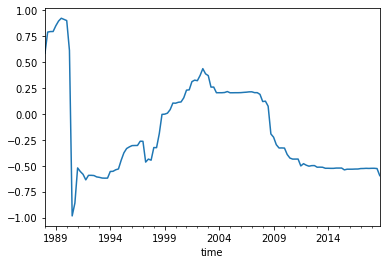

In [52]:
cumulate_R2.loc['co1'].loc['SM'].plot()